# TF_IDF SE Subtracks

In [1]:
import numpy as np
np.random.seed(2342347823)

import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as shc
import matplotlib.pylab as plt
plt.style.use("ggplot") 

from scipy import linalg
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import hamming_loss

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from scipy.sparse import csr_matrix
import json

import sys
sys.setrecursionlimit(10000)

import data_helpers
from data_helpers import *
import imp
imp.reload(data_helpers)

<module 'data_helpers' from '/Users/kyrylo/Projects/personal/thesis/data_helpers.py'>

In [2]:
df_se_skills = pd.read_csv(PREPROCESSED_SE_SKILLS_PATH)
df_se_subtracks = pd.read_csv(PREPROCESSED_SE_TRACKS_PATH)

se_skill_names = list(df_se_skills[SKILL_TAG_LABEL])
skill_names = list_mask(df_se_subtracks.columns.to_list(), se_skill_names)
print('Total skills count:', len(skill_names))

track_names = list_mask(skill_names, list(df_se_skills[df_se_skills[IS_TRACK_NAME_LABEL] == True][SKILL_TAG_LABEL]))
skill_names = list_filter(skill_names, track_names)
country_columns = ['COUNTRY_DE','COUNTRY_EE','COUNTRY_FI','COUNTRY_LT','COUNTRY_LV','COUNTRY_PK']
be_skill_names = df_se_skills[SKILL_TAG_LABEL][df_se_skills[IS_BE_LABEL] == True].to_list()
fe_skill_names = df_se_skills[SKILL_TAG_LABEL][df_se_skills[IS_FE_LABEL] == True].to_list()

for skill in skill_names:
    df_se_subtracks[skill] = np.where(df_se_subtracks[skill] > 0, 1 , 0)

df_se_subtracks

Total skills count: 133


ID  TYPE  SENIORITY  \
0      e66911f13061f2226be06c25     0   1.000000   
1      276911f13061f2226be06c25     0   1.000000   
2      e76911f13061f2226be06c25     0   1.000000   
3      f8343b8716ee6a873cfa2dc5     0   1.000000   
4      296911f13061f2226be06c25     0   0.333333   
...                         ...   ...        ...   
40842  6f28bd2100c4c70e6f99cf15     1   1.000000   
40843  de11cc210041983e4a997f35     1   1.000000   
40844  4ee295210002395f262f3ff5     1   1.000000   
40845  dc00042100a3628f746d5f65     1   1.000000   
40846  b512af3031025ea097ad4086     1   0.666667   

                                                   TITLE  COUNTRY_DE  \
0                                              Developer           0   
1                                   Full Stack Developer           0   
2                                Developer, Scrum Master           0   
3                                              Developer           1   
4                                       Junior developer           0   
...                                                  ...         ...   
40842  Senior/Lead SW developer (Backend/Full Stack/AWS)           0   
40843  Experienced Software Developer (Backend/Fronte...           0   
40844                               Senior PHP developer           0   
40845                    Fullstack developer (part-time)           0   
40846        QA Test Automation / JAVA Software Engineer           0   

       COUNTRY_EE  COUNTRY_FI  COUNTRY_LT  COUNTRY_LV  COUNTRY_PK  ...  \
0               1           0           0           0           0  ...   
1               1           0           0           0           0  ...   
2               1           0           0           0           0  ...   
3               0           0           0           0           0  ...   
4               1           0           0           0           0  ...   
...           ...         ...         ...         ...         ...  ...   
40842           0           1           0           0           0  ...   
40843           0           1           0           0           0  ...   
40844           1           0           0           0           0  ...   
40845           1           0           0           0           0  ...   
40846           1           0           0           0           0  ...   

       software_engineering_tool__unity  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   
...                                 ...   
40842                                 0   
40843                                 0   
40844                                 0   
40845                                 0   
40846                                 0   

       software_engineering_tool__unreal_engine  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   
...                                         ...   
40842                                         0   
40843                                         0   
40844                                         0   
40845                                         0   
40846                                         0   

       software_engineering_tool__vaadin  software_engineering_tool__vagrant  \
0                                      0                                   0   
1                                      0                                   0   
2                                      0                                   0   
3                                      0                                   0   
4                                      0                                   0   
...                                  ...

## Drop profiles with low # of skills

In [3]:
print('Dropped', df_se_subtracks.loc[df_se_subtracks[skill_names].sum(axis=1) <= 2].shape[0])

df_se_subtracks = df_se_subtracks.loc[df_se_subtracks[skill_names].sum(axis=1) > 2]
df_se_subtracks

Dropped 2737


ID  TYPE  SENIORITY  \
0      e66911f13061f2226be06c25     0   1.000000   
1      276911f13061f2226be06c25     0   1.000000   
2      e76911f13061f2226be06c25     0   1.000000   
3      f8343b8716ee6a873cfa2dc5     0   1.000000   
4      296911f13061f2226be06c25     0   0.333333   
...                         ...   ...        ...   
40842  6f28bd2100c4c70e6f99cf15     1   1.000000   
40843  de11cc210041983e4a997f35     1   1.000000   
40844  4ee295210002395f262f3ff5     1   1.000000   
40845  dc00042100a3628f746d5f65     1   1.000000   
40846  b512af3031025ea097ad4086     1   0.666667   

                                                   TITLE  COUNTRY_DE  \
0                                              Developer           0   
1                                   Full Stack Developer           0   
2                                Developer, Scrum Master           0   
3                                              Developer           1   
4                                       Junior developer           0   
...                                                  ...         ...   
40842  Senior/Lead SW developer (Backend/Full Stack/AWS)           0   
40843  Experienced Software Developer (Backend/Fronte...           0   
40844                               Senior PHP developer           0   
40845                    Fullstack developer (part-time)           0   
40846        QA Test Automation / JAVA Software Engineer           0   

       COUNTRY_EE  COUNTRY_FI  COUNTRY_LT  COUNTRY_LV  COUNTRY_PK  ...  \
0               1           0           0           0           0  ...   
1               1           0           0           0           0  ...   
2               1           0           0           0           0  ...   
3               0           0           0           0           0  ...   
4               1           0           0           0           0  ...   
...           ...         ...         ...         ...         ...  ...   
40842           0           1           0           0           0  ...   
40843           0           1           0           0           0  ...   
40844           1           0           0           0           0  ...   
40845           1           0           0           0           0  ...   
40846           1           0           0           0           0  ...   

       software_engineering_tool__unity  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   
...                                 ...   
40842                                 0   
40843                                 0   
40844                                 0   
40845                                 0   
40846                                 0   

       software_engineering_tool__unreal_engine  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   
...                                         ...   
40842                                         0   
40843                                         0   
40844                                         0   
40845                                         0   
40846                                         0   

       software_engineering_tool__vaadin  software_engineering_tool__vagrant  \
0                                      0                                   0   
1                                      0                                   0   
2                                      0                                   0   
3                                      0                                   0   
4                                      0                                   0   
...                                  ...

### Drop minor classes

In [4]:
minor_cluster_names = df_se_subtracks[CLUSTER_LABEL].value_counts().to_frame().query('CLUSTER  < 10').index
rows_from_minro_clasters = df_se_subtracks[CLUSTER_LABEL].isin(minor_cluster_names).to_frame().query('CLUSTER  == True').index

print('Dropped rows:', rows_from_minro_clasters.shape)

df_se_subtracks.drop(rows_from_minro_clasters, inplace=True)
df_se_subtracks.reset_index(drop=True, inplace=True)

df_se_subtracks

Dropped rows: (12834,)


/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


ID  TYPE  SENIORITY  \
0      e66911f13061f2226be06c25     0   1.000000   
1      276911f13061f2226be06c25     0   1.000000   
2      e76911f13061f2226be06c25     0   1.000000   
3      f8343b8716ee6a873cfa2dc5     0   1.000000   
4      39108e16d196f7de86bb7c05     0   1.000000   
...                         ...   ...        ...   
25271  dd41b1210012296e07987fc5     1   1.000000   
25272  6f28bd2100c4c70e6f99cf15     1   1.000000   
25273  de11cc210041983e4a997f35     1   1.000000   
25274  dc00042100a3628f746d5f65     1   1.000000   
25275  b512af3031025ea097ad4086     1   0.666667   

                                                   TITLE  COUNTRY_DE  \
0                                              Developer           0   
1                                   Full Stack Developer           0   
2                                Developer, Scrum Master           0   
3                                              Developer           1   
4                                   Senior iOS Developer           0   
...                                                  ...         ...   
25271                    Senior/Lead Mobile SW developer           0   
25272  Senior/Lead SW developer (Backend/Full Stack/AWS)           0   
25273  Experienced Software Developer (Backend/Fronte...           0   
25274                    Fullstack developer (part-time)           0   
25275        QA Test Automation / JAVA Software Engineer           0   

       COUNTRY_EE  COUNTRY_FI  COUNTRY_LT  COUNTRY_LV  COUNTRY_PK  ...  \
0               1           0           0           0           0  ...   
1               1           0           0           0           0  ...   
2               1           0           0           0           0  ...   
3               0           0           0           0           0  ...   
4               1           0           0           0           0  ...   
...           ...         ...         ...         ...         ...  ...   
25271           0           1           0           0           0  ...   
25272           0           1           0           0           0  ...   
25273           0           1           0           0           0  ...   
25274           1           0           0           0           0  ...   
25275           1           0           0           0           0  ...   

       software_engineering_tool__unity  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     1   
...                                 ...   
25271                                 0   
25272                                 0   
25273                                 0   
25274                                 0   
25275                                 0   

       software_engineering_tool__unreal_engine  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   
...                                         ...   
25271                                         0   
25272                                         0   
25273                                         0   
25274                                         0   
25275                                         0   

       software_engineering_tool__vaadin  software_engineering_tool__vagrant  \
0                                      0                                   0   
1                                      0                                   0   
2                                      0                                   0   
3                                      0                                   0   
4                                      0                                   0   
...                                  ...

In [5]:
X_columns = [*skill_names, *track_names, *country_columns]

X_train, X_val = train_test_split(df_se_subtracks[X_columns], test_size=0.3, random_state=0, stratify=df_se_subtracks['CLUSTER'])


X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)

print(X_train.shape, X_val.shape)

(17693, 139) (7583, 139)


In [6]:
features_set = list(df_se_subtracks[skill_names].sum().sort_values(ascending=False).nlargest(30).index)
features_set

['programming_language__javascript',
 'programming_language__html_css',
 'software_engineering_tool__rest_api',
 'programming_language__sql',
 'programming_language__java',
 'software_engineering_tool__react',
 'software_engineering_tool__mysql',
 'software_engineering_tool__nodejs',
 'programming_language__php',
 'software_engineering_tool__linux',
 'programming_language__csharp',
 'software_engineering_tool__jquery',
 'programming_language__typescript',
 'software_engineering_tool__windows',
 'software_engineering_tool__docker',
 'software_engineering_tool__spring',
 'software_engineering_tool__angular',
 'software_engineering_tool__postgresql',
 'programming_language__python',
 'software_engineering_tool__asp_net',
 'software_engineering_tool__aws',
 'software_engineering_tool__hibernate',
 'software_engineering_tool__vuejs',
 'software_engineering_tool__jenkins',
 'software_engineering_tool__mongodb',
 'software_engineering_tool__laravel',
 'software_engineering_tool__express',
 'p

In [7]:
_X_val = pd.DataFrame(columns=X_train.columns)
_y_val = np.array([])

for skill in features_set:
    X_val_for_skill = X_val.loc[X_val[skill]>0].copy()
    X_val_for_skill[skill] = 0
    _X_val = _X_val.append(X_val_for_skill)
    
    y_val_for_skill = np.repeat(skill, X_val_for_skill.shape[0])
    _y_val = np.append(_y_val, y_val_for_skill)
    

_X_val.reset_index(drop=True, inplace=True)
X_val = _X_val.copy()
y_val = _y_val.copy()

    
print('Train:', X_train.shape, 'Val:', X_val.shape, y_val.shape)

Train: (17693, 139) Val: (42332, 139) (42332,)


In [8]:
tf_idf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tf_idf_transformer.fit(X_train[[*skill_names, *track_names]])


tf_idf = tf_idf_transformer.transform(X_train[[*skill_names, *track_names]])
tf_idf = pd.DataFrame.sparse.from_spmatrix(tf_idf)
tf_idf.columns = [*skill_names, *track_names]
tf_idf

X_train = pd.concat([X_train.drop(columns = [*skill_names, *track_names]), tf_idf], axis=1).dropna()


tf_idf = tf_idf_transformer.transform(X_val[[*skill_names, *track_names]])
tf_idf = pd.DataFrame.sparse.from_spmatrix(tf_idf)
tf_idf.columns = [*skill_names, *track_names]
tf_idf

X_val = pd.concat([X_val.drop(columns = [*skill_names, *track_names]), tf_idf], axis=1).dropna()

In [9]:
X_val_similarities = cosine_similarity(X_train.append(X_val))

In [10]:
def recommend_skills(profile_index_val, k, X_val_similarities, X_val_profiles, X_train_profiles, log_profile=False):
    profile = X_val_profiles.iloc[profile_index_val]
    
    if log_profile:
        print(profile[profile>0])
    
    most_similar_profiles = X_val_similarities[X_train_profiles.shape[0] + profile_index_val].copy()    
    most_similar_profiles  = most_similar_profiles[0:X_train_profiles.shape[0]].copy() # mute val set
    most_similar_profiles = most_similar_profiles.argsort()[::-1][:k]
    
    recommendations = X_train_profiles.iloc[most_similar_profiles].mean().sort_values(ascending=False)
    recommendations.drop(profile[profile>0].index, inplace=True) # mute existing skills
    
    return list_mask(recommendations[recommendations>0].index.to_list(), features_set)
    
    
recommend_skills(profile_index_val=501,
                 k=100,
                 X_val_similarities = X_val_similarities,
                 X_val_profiles = X_val, 
                 X_train_profiles = X_train,
                 log_profile=True)

COUNTRY_DE                                           1
programming_language__html_css                0.324786
programming_language__typescript               0.49155
software_engineering_tool__nodejs             0.433687
software_engineering_tool__vuejs              0.615755
software_engineering__frontend_development    0.292668
Name: 501, dtype: Sparse[object, 0]


['programming_language__javascript',
 'software_engineering_tool__react',
 'software_engineering_tool__angular',
 'software_engineering_tool__rest_api',
 'software_engineering_tool__jquery',
 'software_engineering_tool__express',
 'software_engineering_tool__mongodb',
 'software_engineering_tool__docker',
 'programming_language__php',
 'software_engineering_tool__mysql',
 'software_engineering_tool__react_native',
 'software_engineering_tool__laravel',
 'software_engineering_tool__aws',
 'programming_language__java',
 'software_engineering_tool__postgresql',
 'programming_language__sql',
 'programming_language__python',
 'software_engineering_tool__windows',
 'software_engineering_tool__linux',
 'programming_language__c_cpp',
 'software_engineering_tool__spring',
 'software_engineering_tool__jenkins',
 'software_engineering_tool__asp_net',
 'programming_language__csharp']

In [11]:
def mmr_score(expected, predicted_list, n):
    target_list = predicted_list[:n]
    
    if expected in target_list:
        return 1 / (target_list.index(expected) + 1)
    
    if (len(target_list) < n):
        print('Not enough samples')
        
    return 0

In [13]:
y_pred = []
mmr_scores_10 = []
mmr_scores_5 = []
mmr_scores_3 = []



for ix, profile in X_val.iterrows():
    profile_predictions = recommend_skills(profile_index_val=ix,
                 k=120,
                 X_val_similarities = X_val_similarities,
                 X_val_profiles = X_val, 
                 X_train_profiles = X_train,
                 log_profile=False)

    result = profile_predictions[0]
    
    mmr_scores_10.append(mmr_score(y_val[ix], profile_predictions, 10))
    mmr_scores_5.append(mmr_score(y_val[ix], profile_predictions, 5))
    mmr_scores_3.append(mmr_score(y_val[ix], profile_predictions, 3))

    y_pred.append(result)
    
    sys.stdout.write("\r Profile " + str(ix + 1) + '/' + str(X_val.shape[0]))
    sys.stdout.flush() 


 Profile 42332/42332

acc 0.45251818954927714
recall 0.45251818954927714
precesion 0.45373605549062923
f1 0.4405155928896742
MRR_10 0.6013299537743221
MRR_5 0.5845069923462157
MRR_3 0.5594231314372107


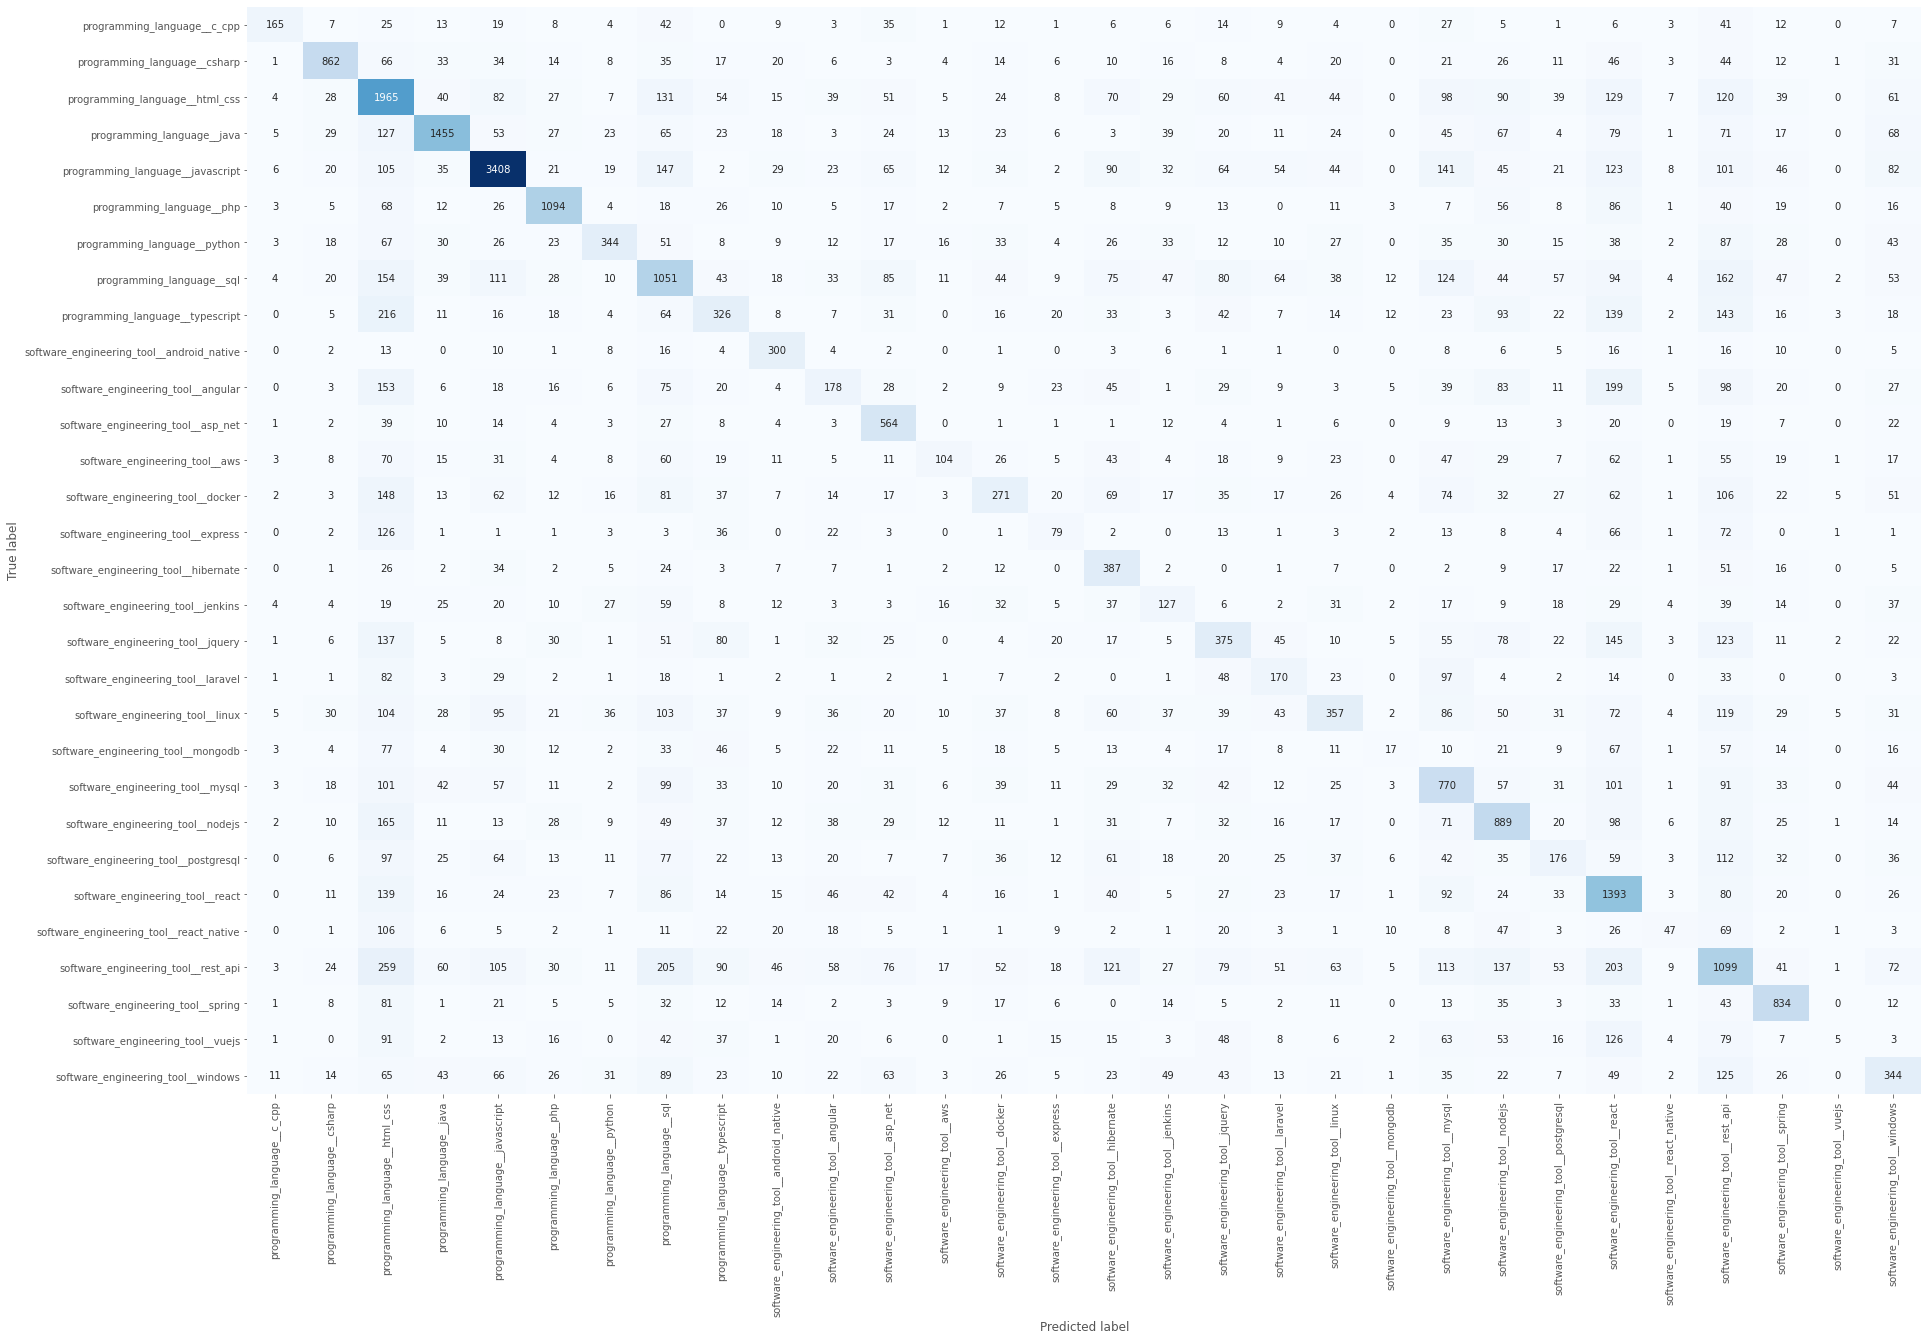

In [14]:
def display_scores(actual, pred):
    print('acc', accuracy_score(actual, pred))
    print('recall', recall_score(actual, pred, average = "weighted"))
    print('precesion', precision_score(actual, pred, average = "weighted"))
    print('f1', f1_score(actual, pred, average = "weighted"))
    print('MRR_10', np.mean(mmr_scores_10))
    print('MRR_5', np.mean(mmr_scores_5))
    print('MRR_3', np.mean(mmr_scores_3))

    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))
    sns.histplot(precision_score(actual, pred, average = None), stat='probability', ax=ax1).set(title='Precision')
    sns.histplot(recall_score(actual, pred, average = None), stat='probability', ax=ax2).set(title='Recall')
    sns.histplot(f1_score(actual, pred, average = None), stat='probability', ax=ax3).set(title='F1')
    plt.show()

display_scores(y_val, y_pred)

make_confusion_matrix(confusion_matrix(y_val, y_pred, labels=np.unique(y_val)), figsize=(30,20), 
                      count=True,
                      percent=False,
                      sum_stats=False,
                      categories=np.unique(y_val), cbar=False)

# acc 0.45251818954927714
# recall 0.45251818954927714
# precesion 0.45373605549062923
# f1 0.4405155928896742

In [ ]:
X_val.loc[
    (
    (X_val >0).astype(int)[skill_names].sum(axis=1)  == 3)
          & (X_val['COUNTRY_EE'] == 1)
          & (X_val['software_engineering__mobile_development']>0)
          & (X_val['software_engineering__frontend_development'] == 0)
#           & (X_val['software_engineering__devops_engineering'] == 0) 
#             & (X_val['software_engineering__data_engineering'] == 0) 
         ][skill_names].index

In [ ]:
index=42098

print(X_val.iloc[index][X_val.iloc[index] > 0].index)


recommend_skills(profile_index_val=index,
                 k=120,
                 X_val_similarities = X_val_similarities,
                 X_val_profiles = X_val, 
                 X_train_profiles = X_train,
                 log_profile=False)
